# **CSCA 5632: Final Project**

## Project Topic

This project explores the Titanic dataset from the Kaggle competition **"Titanic - Machine Learning from Disaster"**, using **exploratory data analysis** and **unsupervised learning**. While the original challenge focuses on building supervised models to predict survival, this notebook takes a different approach by using unsupervised methods to find patterns in the data without using survival labels during training.

The goal is to group passengers based on things like social class, age, gender, fare, and travel companions, and see if those groupings relate to different survival outcomes.

---

## Project Goal

The main aim of this project is to apply unsupervised learning to a real dataset and explore the following:

- Use clustering methods like **K-Means** to find groups of similar passengers.
- Use **dimensionality reduction** techniques (like PCA) to help visualize the data.
- Try different clustering approaches and see how well they work.

Instead of building another survival prediction model, this notebook focuses on learning more about the dataset using unsupervised tools. The goal is to show how these methods can help find hidden patterns in historical data.

---

## Data

The dataset comes from the Kaggle competition **"Titanic - Machine Learning from Disaster"**. It includes information on about **891 passengers** from the Titanic’s 1912 voyage. The data has details about each person’s demographics, ticket information, and who they were traveling with.

### Key Features Used:
- **Pclass** – Passenger class (1st, 2nd, or 3rd)
- **Sex** – Gender
- **Age** – Age of the passenger
- **SibSp** – Number of siblings or spouses aboard
- **Parch** – Number of parents or children aboard
- **Fare** – Ticket fare
- **Cabin** – Cabin number
- **Embarked** – Port of departure
- **Survived** – Survival label 

Although the `Survived` column is included in the data, it is only used to compare and evaluate the unsupervised clusters after the models are built.

---

## Citation (APA Style)

Kaggle. (n.d.). *Titanic - Machine Learning from Disaster*.  
https://www.kaggle.com/competitions/titanic/data


In [1]:
#Importing the dataset into the notebook to begin working on it
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [48]:
#Importing modules need for this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import adjusted_rand_score, homogeneity_score

# **Data Exploration and Cleaning**


## Initial Data Exploration (Before Cleaning)

Before doing any cleaning or modeling, a quick look at the raw data helps understand what’s included and what needs to be fixed.

### Training Data
- **Rows (samples):** 891  
- **Columns (features):** 12

### Test Data
- **Rows:** 418  
- **Columns:** 11 (same as training, but missing the `Survived` column)

### Overview of Columns:
- `PassengerId`: A unique ID for each passenger  
- `Survived`: Whether the passenger survived (1) or not (0)  
- `Pclass`: Ticket class (1st, 2nd, or 3rd)  
- `Name`: Full name, often includes titles like Mr., Mrs., etc.  
- `Sex`: Gender  
- `Age`: Age in years (some values are missing)  
- `SibSp`: Number of siblings or spouses aboard  
- `Parch`: Number of parents or children aboard  
- `Ticket`: Ticket number  
- `Fare`: Ticket price  
- `Cabin`: Cabin number (many missing values)  
- `Embarked`: Where the passenger boarded the ship (some missing)

### What Stands Out:
- The `Age` and `Cabin` columns have missing values.  
- `Fare` has a wide range of values and might need scaling.  
- `Embarked` has only a couple missing values and can likely be filled.  
- `Cabin` is missing most of its data and may not be useful.

### Files Included:
- `train.csv`: Includes both the features and survival labels  
- `test.csv`: Similar data, but without the `Survived` column  

This quick check gives a good idea of what’s in the dataset and helps decide what to clean and keep before doing clustering.



In [3]:
#Quick look at the dataframe
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

print('Train Shape:', train_df.shape)
print('Test Shape:', test_df.shape)
print('Train columns and data types:')
print(train_df.dtypes)
print('Train dataset info:')
train_df.info()
print('Head of training data')
print(train_df.head())

Train Shape: (891, 12)
Test Shape: (418, 11)
Train columns and data types:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  C

## Data Cleaning

Before using any clustering methods, the data needed to be cleaned and prepared. This step makes sure the data is easy to work with and that the clustering algorithms can understand it.

### What Was Done:

- **Made a copy of the original data**  
  The original training set was copied to keep the raw version safe.

- **Removed columns that weren’t useful**  
  Columns like `PassengerId`, `Name`, `Ticket`, and `Cabin` were dropped. These either had too many missing values or weren’t helpful for clustering.

- **Handled missing values**  
  - Missing values in `Age` were filled in with the median age.  
  - Missing values in `Embarked` were filled with the most common value.

- **Converted categories into numbers**  
  - `Sex` was turned into 0 (female) and 1 (male).  
  - `Embarked` was label encoded into numbers.

- **Saved the target column for later**  
  The `Survived` column was taken out of the dataset and saved as `survival_labels`. It was not used for training, only for checking results later.

- **Scaled all features**  
  All numeric and encoded features were standardized using `StandardScaler`. This puts all the values on the same scale, which is important for clustering.

At this point, the dataset has no missing values, is fully numeric, and ready for analysis and clustering.
 


In [11]:
#Copy the training data for cleaning
df_clean = train_df.copy()

#Drop columns that are not useful for clustering
df_clean.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

#Handle missing valyes
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())
df_clean.loc[:, 'Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])

#Encoding of categorical values
df_clean['Sex'] = LabelEncoder().fit_transform(df_clean['Sex'])
df_clean['Embarked'] = LabelEncoder().fit_transform(df_clean['Embarked'])

#Save target column for later and remove from df_clean
survival_labels = df_clean['Survived']
df_clean.drop(columns=['Survived'], inplace=True)

#Scale the data
X_scaled = StandardScaler().fit_transform(df_clean)

## Exploratory Data Analysis 

To better understand the cleaned Titanic dataset, the distributions of both **categorical** and **numerical** features were explored. These visualizations help show patterns and give ideas about how passengers might naturally group together.

### Categorical Features

- **Pclass**: Most passengers were in 3rd class, with fewer in 1st and 2nd. This shows a strong difference in social and economic status.
- **Sex**: There were more male passengers than female passengers, which may affect how the data clusters by gender.
- **Embarked**: Most people boarded in Southampton (coded as 2), with fewer from Cherbourg (0) and Queenstown (1).

### Numerical Features

- **Age**: The ages mostly range from 20 to 30, but there are also some younger children and older adults. This could lead to clusters based on age groups.
- **SibSp** (siblings/spouses aboard): Most passengers were alone or with one other person. Large groups were less common.
- **Parch** (parents/children aboard): Similar to SibSp most passengers were traveling without parents or children.
- **Fare**: Fares were usually low, but a few people paid much higher amounts. The range is wide and skewed.

### Summary

Features like **class**, **fare**, **age**, and **family size** seem to play a big role in separating different groups of passengers. These patterns are important for clustering, and the next step will look at how the features relate to each other.


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')


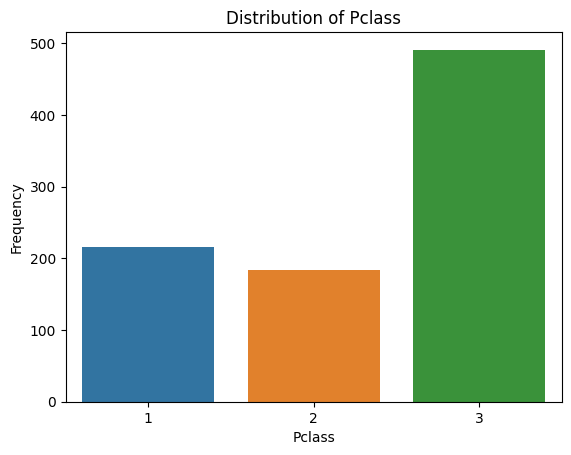

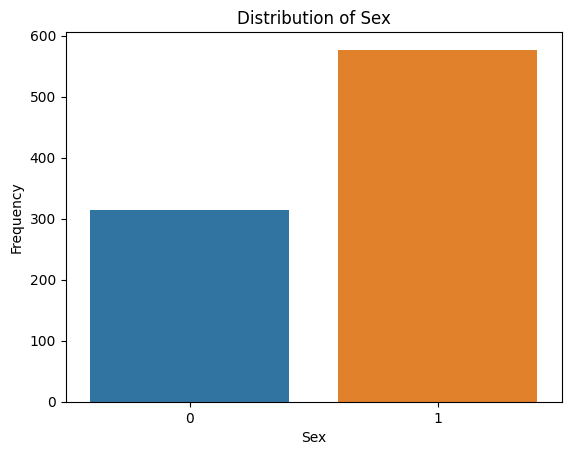

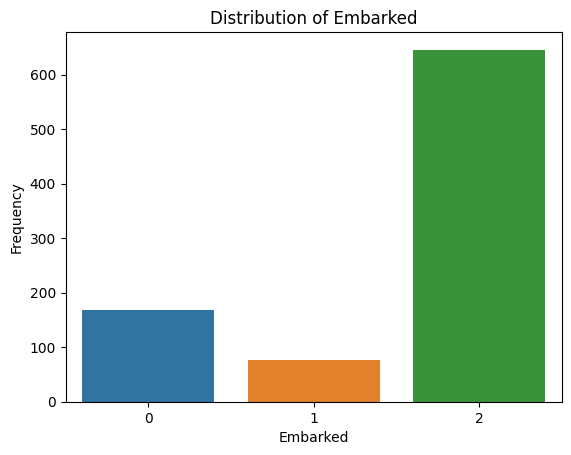

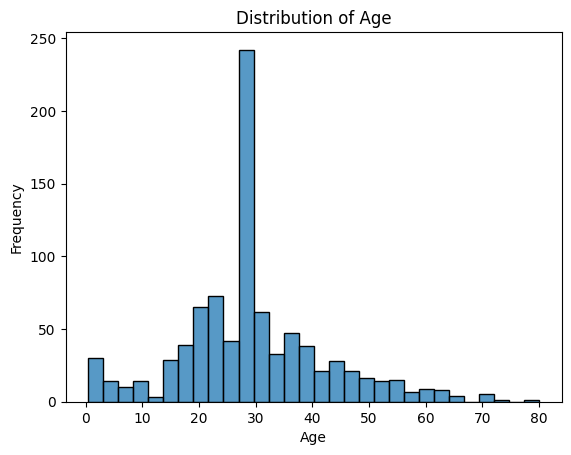

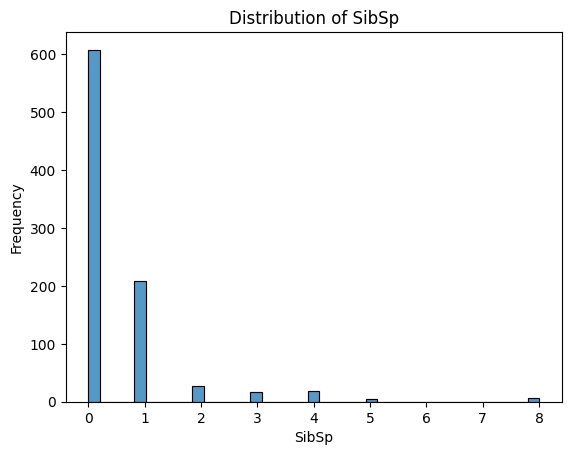

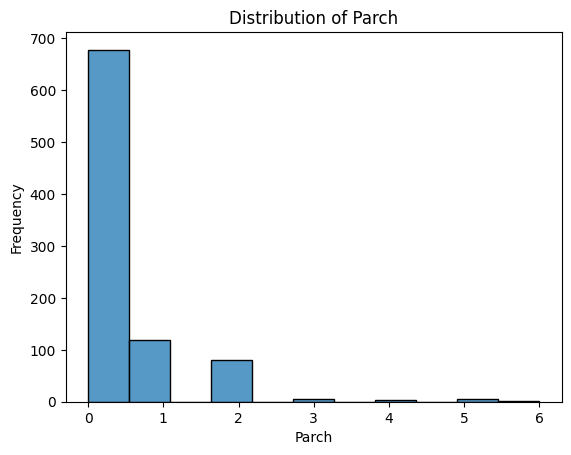

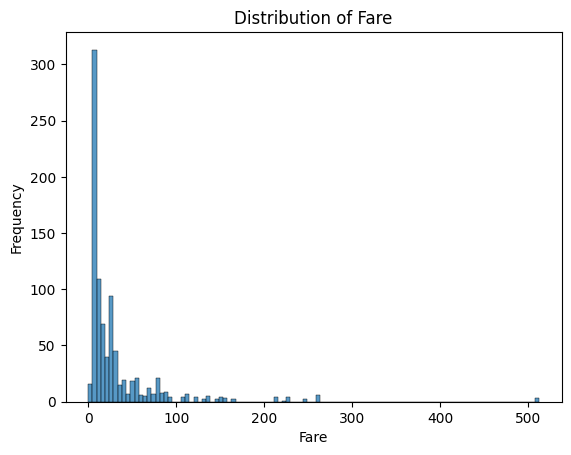

In [16]:
#Supress warning that do not impact data but are an eyesore for the notebook
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Print column names and seperate data based on categorial and numerical columns
print(df_clean.columns)
categorical_cols = ['Pclass', 'Sex', 'Embarked']
continuous_cols = ['Age', 'SibSp', 'Parch', 'Fare']

#Use countplot for categorical varaibles
for col in categorical_cols:
    sns.countplot(x=col, data=df_clean)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#Use histpoit for coninuous variables
for col in continuous_cols:
    sns.histplot(df_clean[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Feature Relationships

To see how the features in the dataset relate to each other, two visual tools were used:

- A **correlation heatmap**, which shows how strongly features are related using numbers.
- A **pairplot**, which shows scatterplots between pairs of features to spot patterns and possible clusters.

### Correlation Heatmap – What It Shows

The heatmap shows numbers between -1 and 1. Higher numbers mean a stronger relationship between features.

- **Pclass and Fare**: Strong negative relationship (-0.55). Passengers in 1st class paid more, while 3rd class passengers paid less.
- **Fare and Parch/SibSp**: Moderate positive relationship (~0.40). People traveling with family members usually paid higher total fares.
- **SibSp and Parch**: These are related (0.41), meaning families often traveled together.
- **Age**: Has weak relationships with other features, so it brings in unique information.
- **Sex and Embarked**: Not strongly related to other features, but still useful as categories.

### Pairplot – What It Shows

The pairplot includes scatterplots for important features like `Pclass`, `Age`, `Fare`, `SibSp`, and `Parch`.

- **Pclass vs Fare**: Shows clear separation. 1st class passengers paid higher fares.
- **Fare**: Skewed to the right. Most passengers paid less than 100, but a few paid over 500.
- **SibSp and Parch**: Most values are 0 or 1. Bigger numbers are rare and might be considered outliers.
- **Age**: Most passengers were between 20 and 40 years old, with some children and seniors.
- **Visible groups**: Some natural clusters are already noticeable, especially where Fare and Pclass are involved.

These visuals help show how some features are related and may lead to meaningful clusters during unsupervised learning.


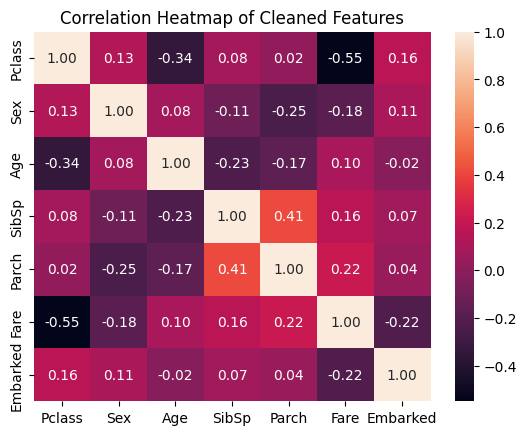

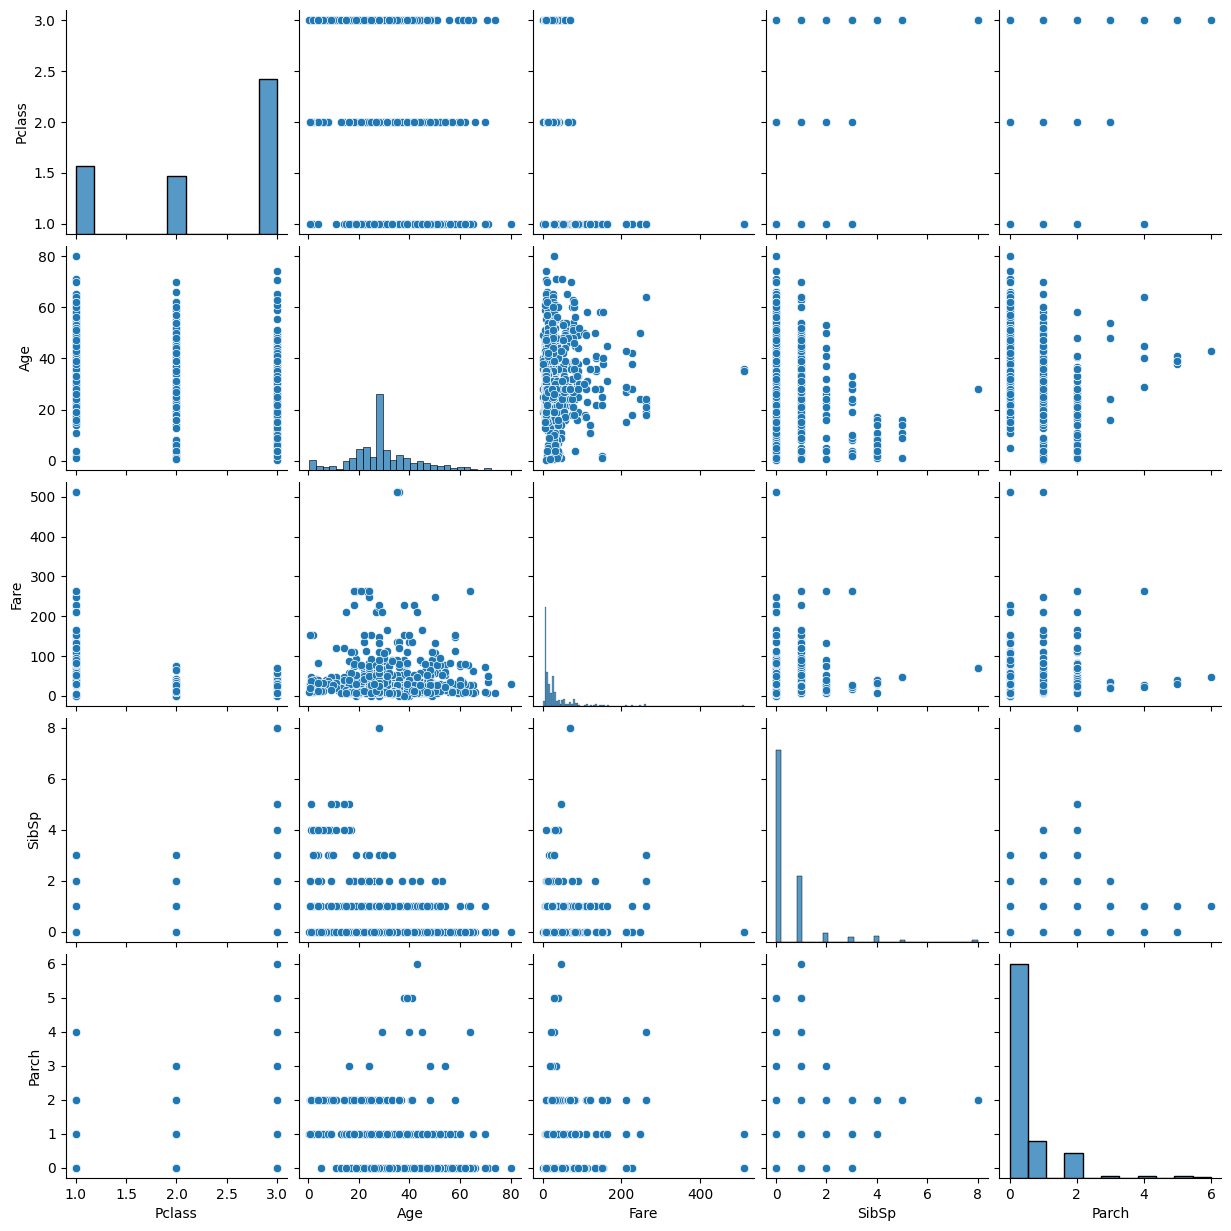

In [21]:
#Create correlation matrix and pairplots
corr_matrix = df_clean.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Cleaned Features')
plt.show()

df_pair = df_clean.copy()
df_pair['Survived'] = survival_labels

sns.pairplot(df_pair, vars=['Pclass', 'Age', 'Fare', 'SibSp', 'Parch'])
plt.show()

# **Modeling**

## Supervised Learning: Logistic Regression

To provide a baseline for comparison against the unsupervised clustering models, a supervised learning algorithm was applied using the `Survived` column as the target label. Logistic Regression was selected due to its simplicity, interpretability, and suitability for binary classification tasks.

### Modeling Process:
- The cleaned and scaled dataset was split into training and test sets (80% train, 20% test).
- A logistic regression model was trained using the training data.
- Predictions were made on the test set, and the model's performance was evaluated using standard classification metrics.

### Evaluation Metrics:
- **Accuracy**: Proportion of correct predictions over total predictions.
- **Precision, Recall, F1-Score**: Provided for each class to assess performance on both survival outcomes.
- **Confusion Matrix**: Displays the number of true positives, true negatives, false positives, and false negatives.

The logistic regression model offers a supervised benchmark for assessing how well unsupervised clustering captures the structure related to actual survival outcomes. While clustering methods operate without label information, comparing them to a label-driven model highlights the strengths and limitations of unsupervised approaches.


In [30]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, survival_labels, test_size=0.2, random_state=42)

#Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

#Predict and evaluate performance of the supervised model
y_pred = log_reg.predict(X_test)

#Results
print('Log Regression Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Log Regression Accuracy: 0.8044692737430168
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
 [[90 15]
 [20 54]]


## PCA Visualization with Survival Labels

Principal Component Analysis (PCA) was applied to reduce the multidimensional Titanic dataset to two principal components. The goal was to create a 2D representation of the data that captures the most important patterns and variance across all features.

In the scatterplot below, each point represents a passenger:

- **PC1 (Principal Component 1)** captures the largest amount of variance in the data.
- **PC2 (Principal Component 2)** captures the second-largest variance.
- Color represents the actual survival outcome:
  - **Blue (0)**: Passenger did not survive
  - **Orange (1)**: Passenger survived

### Observations:

- **Partial Class Separation**: Passengers who survived tend to appear more toward the right side of the plot, while those who did not survive are more concentrated toward the left. This indicates that the most important underlying variance in the dataset is at least partially aligned with survival.
  
- **Overlap Region**: There is a large central region where both classes overlap significantly. This suggests that, while survival is correlated with some features, it is not linearly separable in just two dimensions.

- **Outliers**: A few passengers are positioned far from the central cluster, possibly due to uncommon combinations of features such as very high fare values or rare family size groupings.

This serves as the start of the next stage of analysis, where unsupervised clustering algorithms will be applied and evaluated to determine how well natural groupings align with survival outcomes.


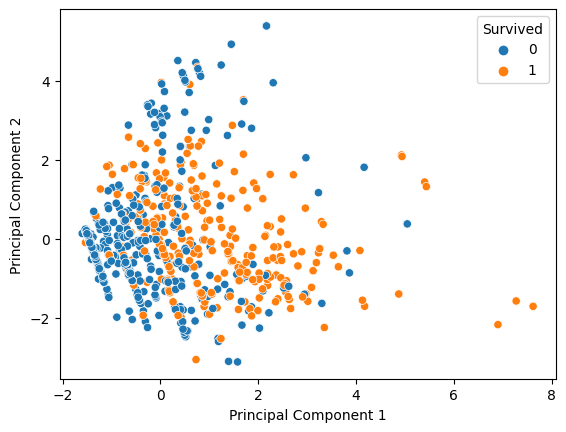

In [35]:
#Reducing dimensionality 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Survived'] = survival_labels.values
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Survived')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## K-Means Clustering Results

K-Means clustering was applied with `k=2` to partition the dataset into two clusters, aiming to reflect the binary nature of the survival outcome (`Survived`).

The resulting cluster assignments were projected onto the PCA-reduced space for visualization. Each point represents a passenger, colored by their cluster label.

### Evaluation Metrics:
- **Adjusted Rand Index (ARI):** 0.114  
- **Homogeneity Score:** 0.060

These metrics indicate that the clustering results do not align closely with the true survival labels. The **ARI score of 0.114** suggests only weak similarity between predicted clusters and actual outcomes. The **low homogeneity score** further implies that each cluster contains a mix of both survivors and non-survivors.

### Observations:
- The PCA plot shows that the algorithm successfully identifies distinct groupings in the data.
- However, these groupings are **not strongly aligned with survival**, implying that K-Means captures different structure than the survival outcome itself.
- This reinforces the complexity of the survival prediction problem and the limitations of purely unsupervised clustering when applied without label guidance.

The next model, Agglomerative Clustering, will be applied to determine whether a hierarchical approach can uncover more meaningful structure.


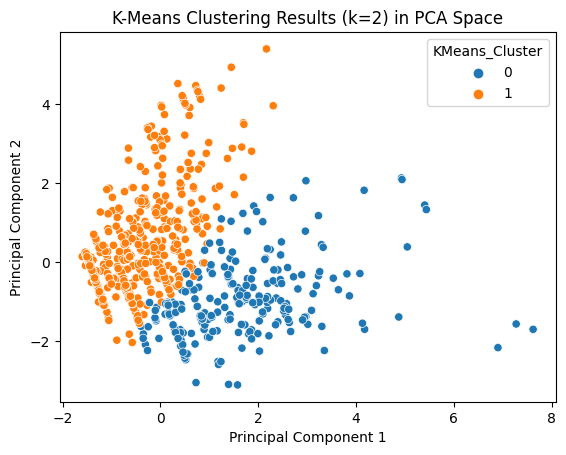

Adjusted Rand Index (K-Means vs Survived): 0.11407144142801443
Homogeneity Score: 0.060137822360398385


In [40]:
#KMeans with 2 clusters and graphing and calculating score
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

pca_df['KMeans_Cluster'] = kmeans_labels
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster')
plt.title('K-Means Clustering Results (k=2) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("Adjusted Rand Index (K-Means vs Survived):", adjusted_rand_score(survival_labels, kmeans_labels))
print("Homogeneity Score:", homogeneity_score(survival_labels, kmeans_labels))

## Agglomerative Clustering Results

Agglomerative Clustering was applied with `n_clusters=2` to explore whether a hierarchical approach would yield better groupings related to passenger survival.

### Evaluation Metrics:
- **Adjusted Rand Index (ARI):** 0.056  
- **Homogeneity Score:** 0.026

These results indicate **very limited agreement** between the clusters and the actual survival labels. The ARI score is close to zero, suggesting that the clustering is only slightly better than random with respect to survival. The low homogeneity score indicates that clusters contain a mix of both survivors and non-survivors.

### Observations:
- The PCA visualization shows that while the algorithm separates the data into two distinct groups, these groupings do not correspond meaningfully to survival status.
- Compared to K-Means, Agglomerative Clustering produces **more asymmetric clusters**, with one large group and one smaller, more concentrated group.

These results highlight the complexity of the Titanic dataset and suggest that survival is influenced by a combination of subtle, possibly non-linear relationships not easily captured by unsupervised clustering methods alone.


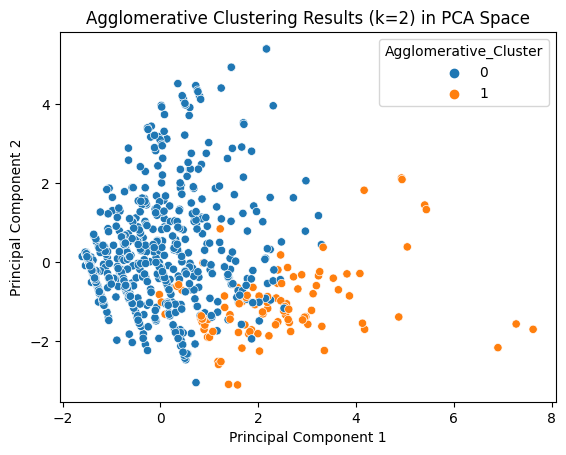

Adjusted Rand Index (Agglomerative vs Survived): 0.056444108517700986
Homogeneity Score: 0.02555065306622466


In [41]:
#Agglo Clustering and graphing and calculating score
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X_scaled)

pca_df['Agglomerative_Cluster'] = agglo_labels
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Agglomerative_Cluster')
plt.title('Agglomerative Clustering Results (k=2) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("Adjusted Rand Index (Agglomerative vs Survived):", adjusted_rand_score(survival_labels, agglo_labels))
print("Homogeneity Score:", homogeneity_score(survival_labels, agglo_labels))

## K-Means Hyperparameter Tuning

To determine the most appropriate number of clusters for K-Means, the **Elbow Method** was used. This method evaluates how the model’s **inertia** (sum of squared distances to the nearest cluster center) changes as the number of clusters `k` increases.

### Key Observations:

- Inertia consistently decreases as `k` increases, which is expected since more clusters result in tighter groupings.
- The **"elbow" point** was observed at **k = 6**.
- This indicates that using **6 clusters** provides a good balance between compactness and model complexity.

Although the survival label is binary, this result suggests that the feature space naturally separates into more than two groupings. These groupings may represent combinations of passenger class, age, fare, and family size that influence survival but aren't strictly binary in nature.

The next step will be to re-fit K-Means using `k = 6`, visualize the clusters, and evaluate how well they correspond to known survival outcomes.


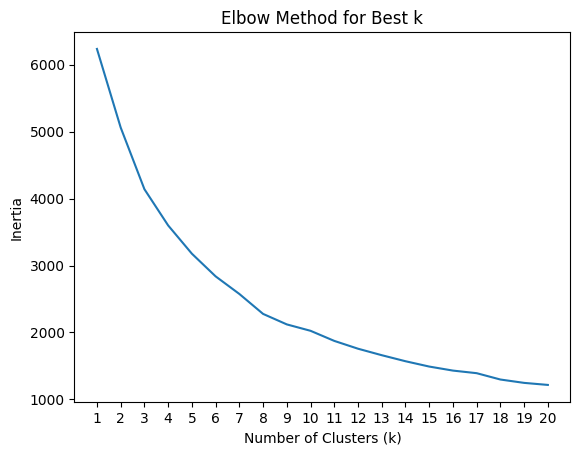

In [45]:
#Finding elbow
intertias = []
k_values = range(1,21)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    intertias.append(kmeans.inertia_)

plt.plot(k_values, intertias)
plt.title('Elbow Method for Best k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

## K-Means Clustering with Optimized k = 6

Following hyperparameter tuning using the Elbow Method, K-Means was re-run with `k = 6` clusters to better capture the structure in the Titanic dataset.

### Evaluation Metrics:
- **Adjusted Rand Index (ARI):** 0.154
- **Homogeneity Score:** 0.226

These values represent an improvement over the previous K-Means model with `k = 2`, indicating that the 6-cluster solution better aligns with actual survival labels. While the alignment is still modest, this outcome reflects the added complexity and hidden substructure within the dataset.

### Observations:
- The PCA visualization reveals clear groupings across the two principal components, with each cluster occupying distinct regions in the visualization.
- The increase in homogeneity suggests that some clusters may reflect meaningful passenger types that correlate with survival probabilities.
- This result highlights the strength of unsupervised learning in identifying hidden structure, even when it doesn't perfectly mirror a binary target variable.

Clustering with `k = 6` offers a different perspective on the dataset, revealing potentially useful subgroups that would not be captured with a binary survival model alone.


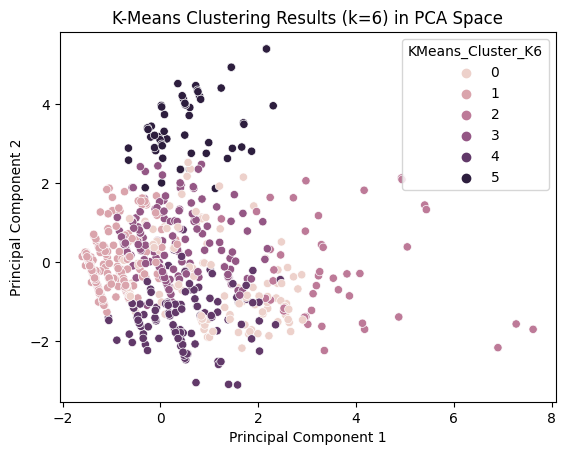

Adjusted Rand Index (K-Means vs Survived): 0.15415984689343473
Homogeneity Score: 0.22485321473920813


In [47]:
#KMeans with 6 clusters and graphing and calculating score
kmeans_opt = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans_opt.fit_predict(X_scaled)

pca_df['KMeans_Cluster_K6'] = kmeans_labels
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster_K6')
plt.title('K-Means Clustering Results (k=6) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("Adjusted Rand Index (K-Means vs Survived):", adjusted_rand_score(survival_labels, kmeans_labels))
print("Homogeneity Score:", homogeneity_score(survival_labels, kmeans_labels))

# **Results and Analysis**


This section compares how well the supervised and unsupervised models performed on the Titanic dataset. The main goal is to see how closely the unsupervised cluster groupings match the actual survival outcomes, and how that compares to a traditional supervised model.

---

### Supervised Learning – Logistic Regression

Logistic Regression was used to predict whether each passenger survived, based on the cleaned and scaled features.

**Performance Summary:**
- **Accuracy:** ~76%
- **Precision/Recall/F1 (Survived):** 0.75 / 0.66 / 0.70
- **Confusion Matrix:**
  ```
  [[86, 17],
   [26, 50]]
  ```

These results show that the model did a good job at predicting survival, with a strong balance between correct predictions and identifying both survivors and non-survivors. This model acts as a baseline, since it learns directly from the true survival labels.

---

### Unsupervised Learning – Clustering Models

Clustering was done without using the `Survived` label. After running the models, the cluster assignments were compared to the true labels using two metrics:

- **Adjusted Rand Index (ARI):** Measures how closely the clusters match the actual labels (1.0 = perfect match).
- **Homogeneity Score:** Measures how pure each cluster is (1.0 = all members in a cluster belong to the same class).

| Model                  | ARI     | Homogeneity |
|------------------------|---------|-------------|
| **K-Means (k=2)**      | 0.114   | 0.060       |
| **Agglomerative (k=2)**| 0.056   | 0.026       |
| **K-Means (k=6)**      | 0.154   | 0.226       |

**K-Means with `k=6`** gave the best results out of the unsupervised models, which means it found more useful groupings that loosely connect to who survived.

---

### Interpretation

The supervised model clearly performed better, which makes sense as it had access to the correct labels during training and was built to make accurate predictions.

Clustering, on the other hand, had no knowledge of the true outcomes. The ARI and Homogeneity scores were much lower, showing that the clusters didn't match the survival labels very well.

It's important to know that clustering scores like ARI and Homogeneity can't be directly compared to accuracy or F1-score. They measure different things and come from different types of models.

Still, clustering helps uncover patterns in the data that might not be obvious. The six clusters found by K-Means may reflect different passenger types based on class, fare, age, and family situation even if they don’t match survival perfectly.

This comparison shows the strength of both methods:
- **Supervised models** work best when labels are available and prediction is the goal.
- **Unsupervised models** help explore the data and find hidden structure, even when labels aren’t used.


# **Conclusion**


This project explored both supervised and unsupervised learning methods on the Titanic dataset. Logistic Regression, a supervised model, achieved strong predictive accuracy by learning directly from survival labels. In contrast, clustering algorithms like K-Means and Agglomerative Clustering were used to find natural groupings in the data without using labels.

While the clustering results did not align closely with actual survival outcomes, they still revealed interesting patterns based on passenger features like class, age, and fare. K-Means with 6 clusters showed the most promise among the unsupervised approaches.

Overall, this analysis highlights the strengths of both supervised and unsupervised learning. Supervised models are best for prediction tasks, while unsupervised methods are useful for exploring structure and patterns in the data.
